In [260]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

path = './input/task3/'

%run utils.py

In [232]:
colors = ['ffffff', '00ff00', '0000ff', 'ff0000', 'ff00ff', '00ffff', 'ffff00', '66ff00']
def get_color(n):
    color = colors[n]
    r = int(color[0:2],16)
    g = int(color[2:4],16)
    b = int(color[4:6],16)
    return (b,r,g)

In [238]:
def show_points(num_order):
    img = cv2.imread(path + "img-%02d.jpg" % num_order)
    pnts = points[num_order]
    for k in range(0, len(pnts)):
        cv2.circle(img, (int(pnts[k][0]),int(pnts[k][1])),5,get_color(k), -1)
#         cv2.circle(img, (int(pnts[k][0]),int(pnts[k][1])),3,get_color(k))

    cv2_imshow(img)

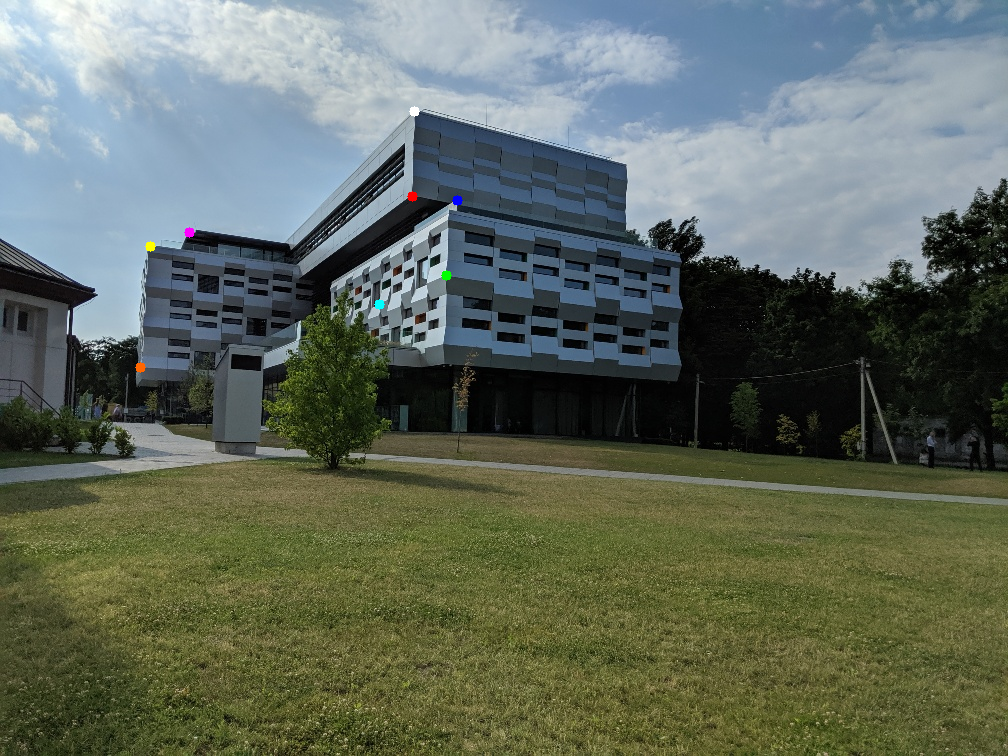

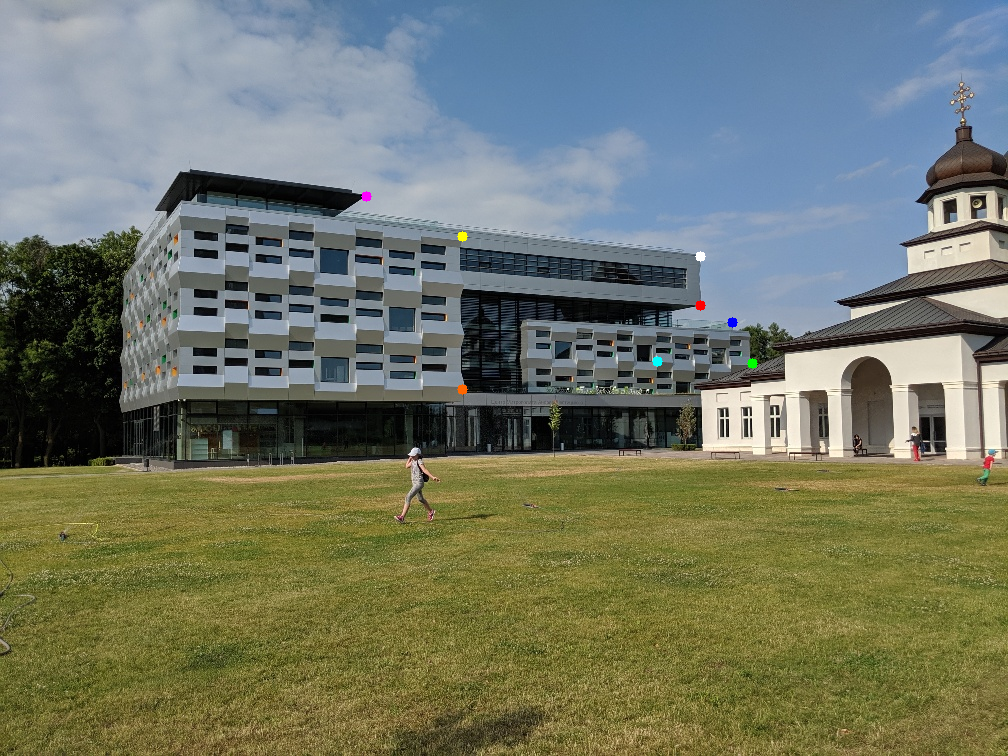

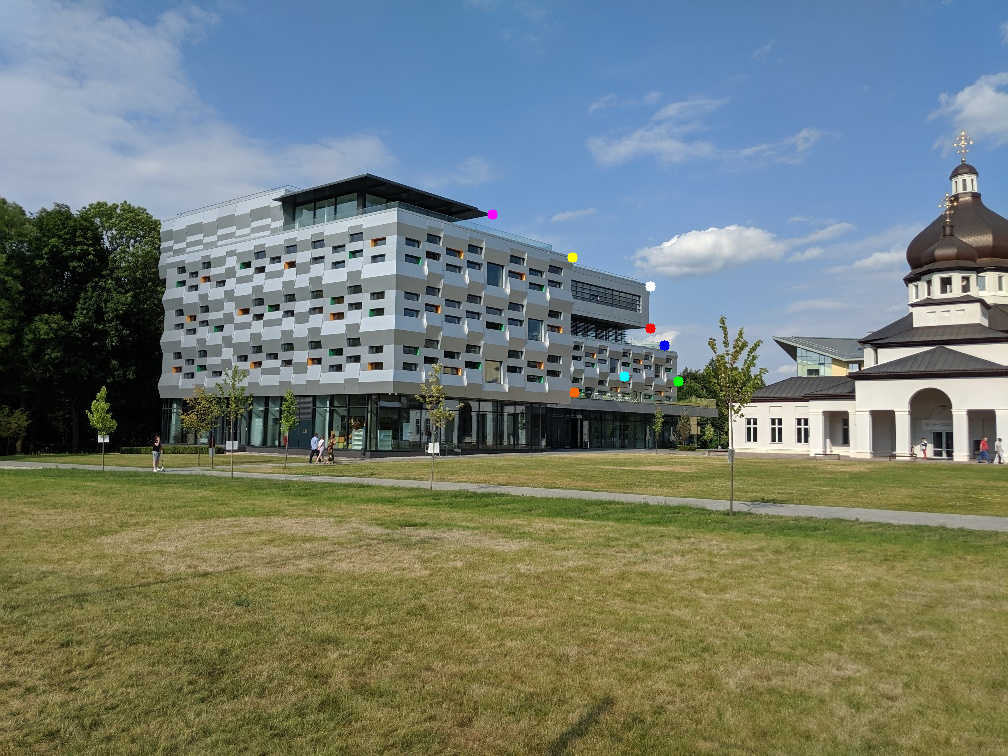

In [239]:
points = np.array([
    [[414, 111], [412, 196], [457, 200], [446, 275], [379, 304], [189, 232], [150, 246], [140, 367]],
    [[700, 256], [700, 305], [732, 322], [752, 363], [657, 361], [366, 196], [462, 236], [462, 389]],
    [[650, 286], [650, 328], [664, 345], [678, 381], [624, 376], [492, 214], [572, 257], [574, 392]],
])
show_points(0)
show_points(1)
show_points(2)

In [324]:
def normalize2dpts(pts):
    
    pts = pts.reshape(3,-1)
    
    if pts.shape[0]!=3:
        raise ShapeError('pts must be 3xN')
    
    finiteind = np.abs(pts[2]) > np.finfo(float).eps
    pts[0,finiteind] = pts[0,finiteind]/pts[2,finiteind]
    pts[1,finiteind] = pts[1,finiteind]/pts[2,finiteind]
    pts[2,finiteind] = 1
    
    # Centroid of finite points
    c = [np.mean(pts[0,finiteind]), np.mean(pts[1,finiteind])] 
    
    # Shift origin to centroid.
    newp0 = pts[0,finiteind]-c[0] 
    newp1 = pts[1,finiteind]-c[1] 

    meandist = np.mean(np.sqrt(newp0**2 + newp1**2));
    
    scale = np.sqrt(2)/meandist;
    '''
    T = [scale   0   -scale*c(1)
         0     scale -scale*c(2)
         0       0      1      ];
    '''
    T = np.eye(3)
    T[0][0] = scale
    T[1][1] = scale
    T[0][2] = -scale*c[0]
    T[1][2] = -scale*c[1]
    newpts = np.dot(T, pts)    
    
    return newpts, T

In [329]:
# function return fundamental matrix
def get_fundamental_matrix(points1, points2):
    pts1 = np.array(points1)
    pts2 = np.array(points2)

    # stack points
    pts1 = np.vstack((pts1.T, np.ones(len(pts1)))).T
    pts2 = np.vstack((pts2.T, np.ones(len(pts2)))).T
    
    # normalize points    
    x1, T1 = normalize2dpts(pts1)
    x2, T2 = normalize2dpts(pts2)


    npts = x1.shape[1]
    # stack column by column
    A = np.c_[x2[0]*x1[0], x2[0]*x1[1], x2[0], x2[1]*x1[0], x2[1]*x1[1], x2[1], x1[0], x1[1], np.ones((npts,1))]
    
    (U, S, V) = np.linalg.svd(A)
    V = V.conj().T
    F = V[:,8].reshape(3,3).copy()
    
    # force F to be rank 2 matrix
    (U,D,V) = np.linalg.svd(F);
    F = np.dot(np.dot(U,np.diag([D[0], D[1], 0])),V);
    
    F = np.dot(np.dot(T2.T,F),T1);
    
    F = F / F[2,2]
    return F

get_fundamental_matrix(points[0], points[1])

array([[-10.09439476,  22.24783855,  17.0820912 ],
       [ -4.51632379,  -5.68759484,  -7.59886789],
       [ -9.54165958,   5.48544714,   1.        ]])

In [328]:
f, _ = cv2.findFundamentalMat(points[0], points[1], cv2.FM_LMEDS)
f

array([[ 6.07717589e-05,  4.46763299e-05, -7.82557791e-03],
       [-1.54445945e-04,  5.87263869e-05, -2.64646631e-02],
       [ 1.19381652e-02, -6.53321654e-04,  1.00000000e+00]])

In [277]:
def draw_epipolar_line(img, p1, F, color):
    h, w, _ = img.shape
    
    p1 = np.append(p1, 1)
    
    p2 = np.matmul(F, p1)
    
    lp1 = (0, int(-p2[2]/p2[1]) )
    lp2 = (w, int(-(p2[0] * w + p2[2]) / p2[1]) )
    
#     print(lp1, lp2)
    
    return cv2.line(img, lp1, lp2, color, 1)

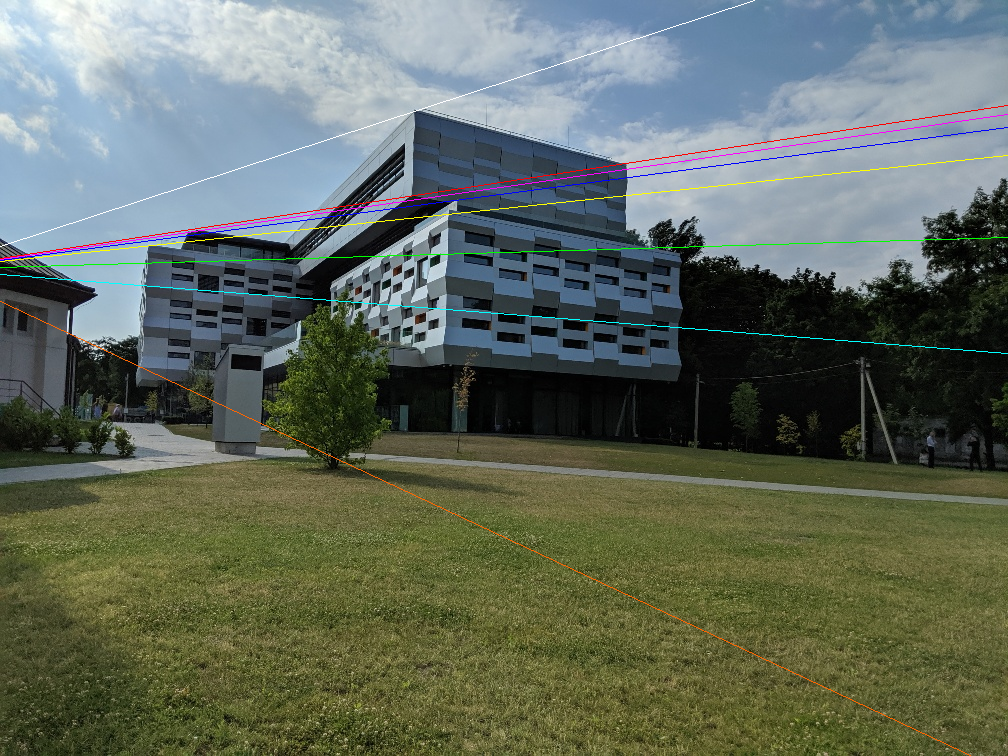

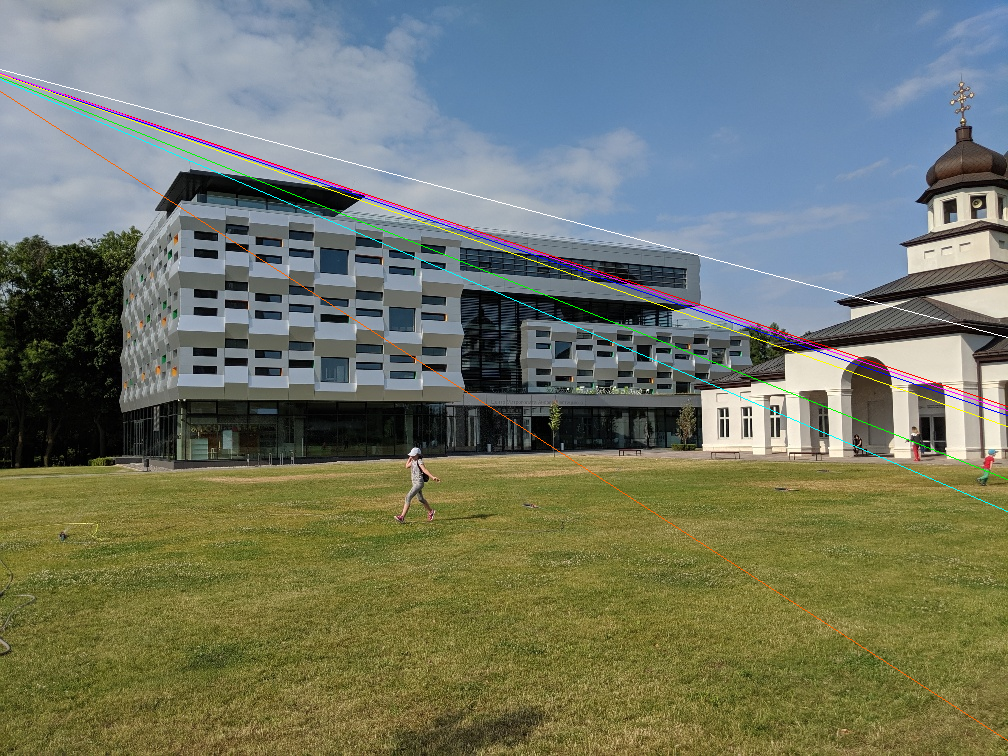

In [336]:
def draw_epipolar_lines(n1, n2):

    img1 = cv2.imread(path + "img-%02d.jpg" % n1 )
    img2 = cv2.imread(path + "img-%02d.jpg" % n2 )

#     F1 = get_fundamental_matrix(points[n1], points[n2])
#     F2 = get_fundamental_matrix(points[n2], points[n1])

    F1, _ = cv2.findFundamentalMat(points[n1], points[n2], cv2.FM_LMEDS)
    F2, _ = cv2.findFundamentalMat(points[n2], points[n1], cv2.FM_LMEDS)

    for i in range(len(points[n1])):    
        img2 = draw_epipolar_line(img2, points[n1][i], F1, get_color(i))
        img1 = draw_epipolar_line(img1, points[n2][i], F2, get_color(i))
    
        
    cv2_imshow(img1)
    cv2_imshow(img2)

draw_epipolar_lines(0, 1)